<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/Copie_de_dlprojet1112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **charge des données :**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meryemdouider","key":"71abdf1b37f401d9b4f539d2b43177eb"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download "andrewmvd/ocular-disease-recognition-odir5k"

100% 1.62G/1.62G [00:12<00:00, 178MB/s]
100% 1.62G/1.62G [00:12<00:00, 136MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/

# **préparation des données:**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
#from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal
import keras

In [ ]:
data_df = pd.read_excel(open("/content/ODIR-5K/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')  

In [ ]:
data_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
print(data_df.loc[(data_df.N==1)].shape)
print(data_df.loc[data_df.N==0].shape)

(1140, 15)
(2360, 15)


In [ ]:
print(data_df.loc[(data_df.D==1)].shape)
print(data_df.loc[data_df.D==0].shape)

(1128, 15)
(2372, 15)


In [ ]:
print(data_df.loc[(data_df.C==1)].shape)
print(data_df.loc[data_df.C==0].shape)

(212, 15)
(3288, 15)


In [ ]:
print(data_df.loc[(data_df.A==1)].shape)
print(data_df.loc[data_df.A==0].shape)

(164, 15)
(3336, 15)


In [ ]:
print(data_df.loc[(data_df.H==1)].shape)
print(data_df.loc[data_df.H==0].shape)

(103, 15)
(3397, 15)


In [ ]:
print(data_df.loc[(data_df.M==1)].shape)
print(data_df.loc[data_df.M==0].shape)

(174, 15)
(3326, 15)


In [ ]:
print(data_df.loc[(data_df.O==1)].shape)
print(data_df.loc[data_df.O==0].shape)

(979, 15)
(2521, 15)


In [ ]:
print(data_df.loc[(data_df.G==1)].shape)
print(data_df.loc[data_df.G==0].shape)

(215, 15)
(3285, 15)


In [ ]:
data_df.loc[(data_df.N==1)]['Left-Diagnostic Keywords'].value_counts()

normal fundus                    1023
lens dust，normal fundus            86
normal fundus，lens dust            25
normal fundus，normal fundus         2
low image quality                   2
lens dust，lens dust                 1
lens dust，lens dust，lens dust       1
Name: Left-Diagnostic Keywords, dtype: int64

In [ ]:
data_df.loc[(data_df.N==1)]['Right-Diagnostic Keywords'].value_counts()

normal fundus              1033
lens dust，normal fundus      88
normal fundus，lens dust      18
low image quality             1
Name: Right-Diagnostic Keywords, dtype: int64

In [ ]:
def has_normal_mentioned(text):
    if 'normal' in text:
        return 1
    else:
        return 0

In [ ]:
data_df['le_normal'] = data_df['Left-Diagnostic Keywords'].apply(lambda x: has_normal_mentioned(x))
data_df['re_normal'] = data_df['Right-Diagnostic Keywords'].apply(lambda x: has_normal_mentioned(x))

In [ ]:
data_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,le_normal,re_normal
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,0,1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,1,1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,1,0
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,0,0


In [ ]:
normal_le_list = data_df.loc[(data_df.N==1) & (data_df.le_normal==1)]["Left-Fundus"].values
normal_re_list = data_df.loc[(data_df.N==1) & (data_df.re_normal==1)]['Right-Fundus'].values
print(len(normal_le_list), len(normal_re_list))


1136 1139


In [ ]:
normal_le_list

array(['1_left.jpg', '8_left.jpg', '84_left.jpg', ..., '3485_left.jpg',
       '4571_left.jpg', '4637_left.jpg'], dtype=object)

In [ ]:
normal_re_list

array(['1_right.jpg', '8_right.jpg', '84_right.jpg', ...,
       '4290_right.jpg', '4571_right.jpg', '4637_right.jpg'], dtype=object)

In [ ]:
infecté_le_list = data_df.loc[(data_df.N==0) & (data_df.le_normal==0)]["Left-Fundus"].values
infecté_re_list = data_df.loc[(data_df.N==0) & (data_df.re_normal==0)]['Right-Fundus'].values
print(len(infecté_le_list), len(infecté_re_list))

1916 1975


In [ ]:
infecté_le_list

array(['0_left.jpg', '2_left.jpg', '4_left.jpg', ..., '4689_left.jpg',
       '4690_left.jpg', '4784_left.jpg'], dtype=object)

In [ ]:
infecté_re_list

array(['2_right.jpg', '3_right.jpg', '4_right.jpg', ..., '4688_right.jpg',
       '4690_right.jpg', '4784_right.jpg'], dtype=object)

In [ ]:
normal_f = np.concatenate((normal_le_list, normal_re_list), axis = 0)
infecté_f = np.concatenate((infecté_le_list, infecté_re_list), axis = 0)
print(len(normal_f), len(infecté_f))

2275 3891


In [ ]:
len(infecté_f )

3891

In [ ]:
for i in range(3890):
    print(infecté_f[i])

0_left.jpg
2_left.jpg
4_left.jpg
5_left.jpg
6_left.jpg
7_left.jpg
10_left.jpg
11_left.jpg
12_left.jpg
13_left.jpg
17_left.jpg
18_left.jpg
19_left.jpg
20_left.jpg
21_left.jpg
22_left.jpg
23_left.jpg
26_left.jpg
28_left.jpg
29_left.jpg
30_left.jpg
31_left.jpg
32_left.jpg
34_left.jpg
35_left.jpg
36_left.jpg
37_left.jpg
38_left.jpg
39_left.jpg
40_left.jpg
41_left.jpg
43_left.jpg
44_left.jpg
45_left.jpg
46_left.jpg
47_left.jpg
48_left.jpg
49_left.jpg
50_left.jpg
53_left.jpg
55_left.jpg
61_left.jpg
62_left.jpg
64_left.jpg
65_left.jpg
66_left.jpg
67_left.jpg
70_left.jpg
71_left.jpg
72_left.jpg
73_left.jpg
74_left.jpg
75_left.jpg
76_left.jpg
77_left.jpg
78_left.jpg
79_left.jpg
81_left.jpg
86_left.jpg
87_left.jpg
89_left.jpg
90_left.jpg
93_left.jpg
95_left.jpg
96_left.jpg
98_left.jpg
99_left.jpg
100_left.jpg
101_left.jpg
102_left.jpg
103_left.jpg
104_left.jpg
105_left.jpg
106_left.jpg
108_left.jpg
109_left.jpg
110_left.jpg
111_left.jpg
113_left.jpg
114_left.jpg
115_left.jpg
116_left.jpg
118_lef

In [ ]:
#affichage des images :

In [ ]:
from PIL import Image

In [ ]:
im = Image.open('/content/ODIR-5K/ODIR-5K/Training Images/0_left.jpg')

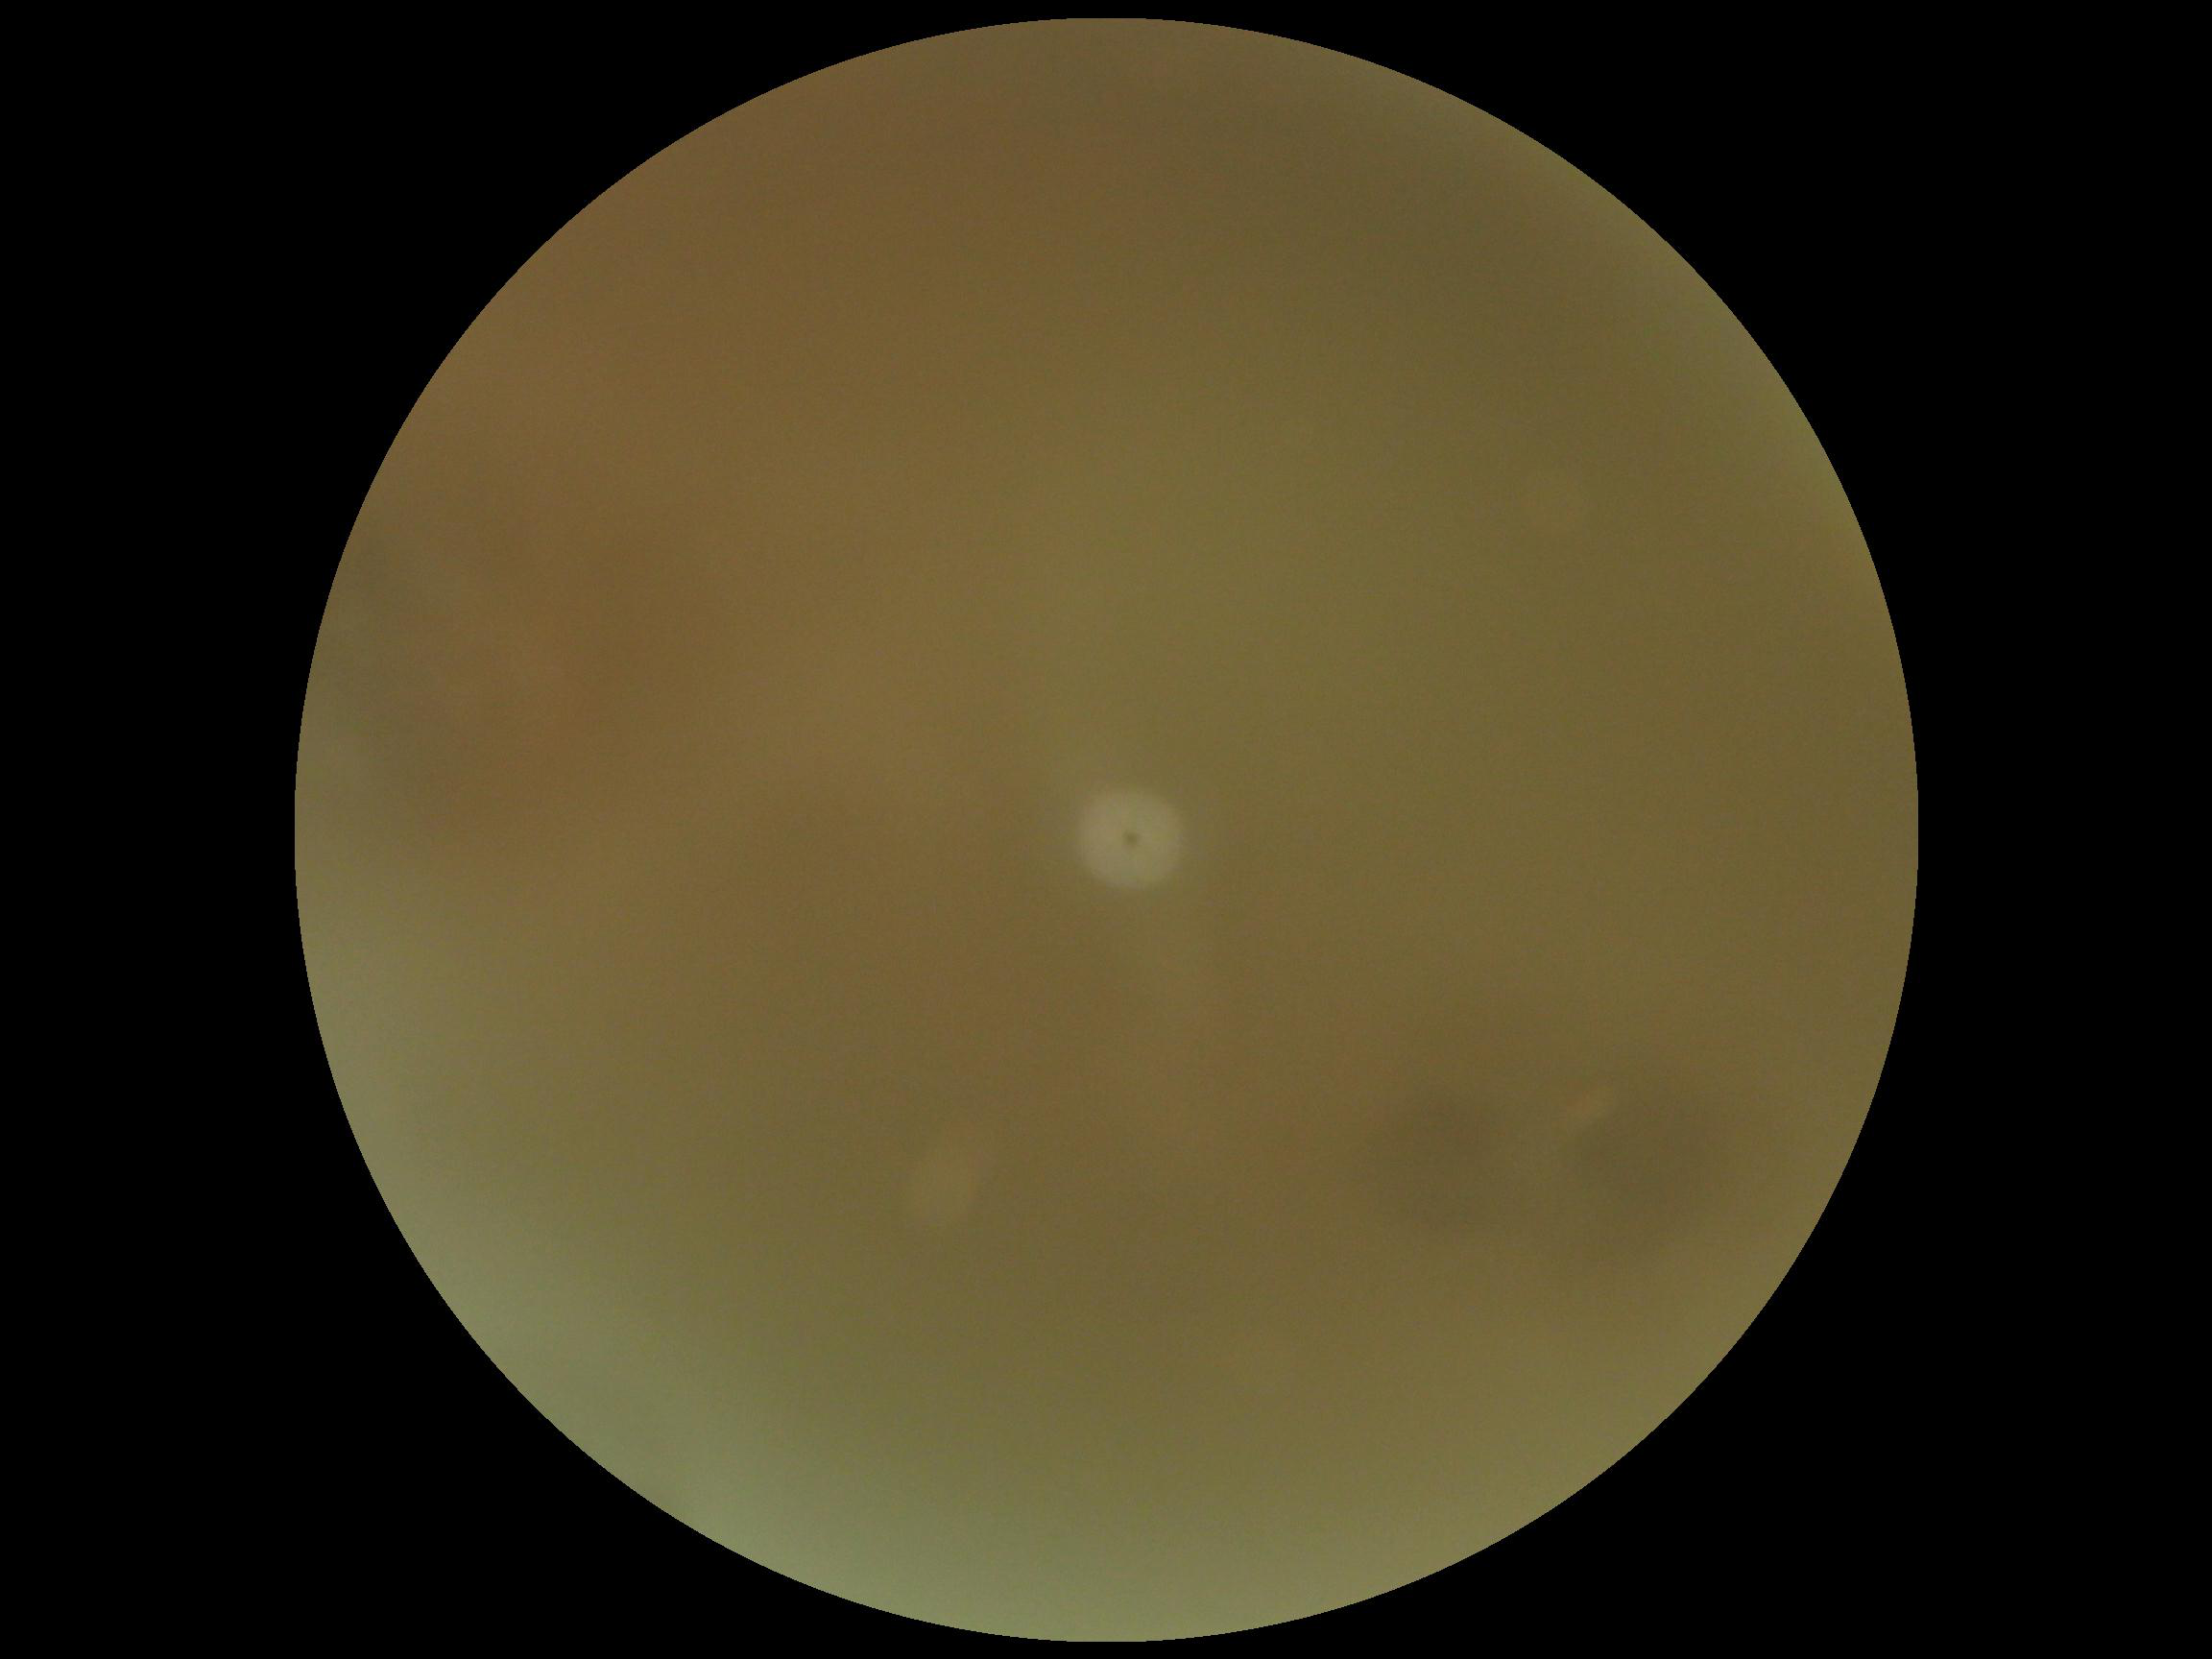

In [ ]:
im

In [ ]:
import imageio
IMAGE_DATA= "/content/ODIR-5K/ODIR-5K/Training Images"

In [ ]:
IMAGE_DATA

'/content/ODIR-5K/ODIR-5K/Training Images'

In [ ]:
print(len(os.listdir(IMAGE_DATA)))

7000


In [ ]:
from tqdm import tqdm

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline 

In [ ]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list,IMAGE_DATA, is_normal):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(IMAGE_DATA,img)
        label = label_image(is_normal)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [ ]:
len(normal_f)

2275

In [ ]:
normal_f[2274]

'4637_right.jpg'

In [ ]:
for i in range(2275):
      print(normal_f[i])

1_left.jpg
8_left.jpg
84_left.jpg
191_left.jpg
394_left.jpg
530_left.jpg
695_left.jpg
832_left.jpg
939_left.jpg
951_left.jpg
1034_left.jpg
1054_left.jpg
1060_left.jpg
1072_left.jpg
1253_left.jpg
2329_left.jpg
2330_left.jpg
2331_left.jpg
2332_left.jpg
2333_left.jpg
2334_left.jpg
2335_left.jpg
2336_left.jpg
2337_left.jpg
2338_left.jpg
2339_left.jpg
2340_left.jpg
2341_left.jpg
2342_left.jpg
2343_left.jpg
2344_left.jpg
2345_left.jpg
2346_left.jpg
2347_left.jpg
2348_left.jpg
2349_left.jpg
2350_left.jpg
2351_left.jpg
2352_left.jpg
2353_left.jpg
2354_left.jpg
2355_left.jpg
2356_left.jpg
2357_left.jpg
2358_left.jpg
2359_left.jpg
2360_left.jpg
2361_left.jpg
2362_left.jpg
2363_left.jpg
2364_left.jpg
2365_left.jpg
2366_left.jpg
2367_left.jpg
2368_left.jpg
2369_left.jpg
2370_left.jpg
2371_left.jpg
2372_left.jpg
2373_left.jpg
2374_left.jpg
2375_left.jpg
2376_left.jpg
2377_left.jpg
2378_left.jpg
2379_left.jpg
2380_left.jpg
2381_left.jpg
2382_left.jpg
2383_left.jpg
2384_left.jpg
2385_left.jpg
2386_le

In [ ]:
norm_df = process_data(normal_f, IMAGE_DATA, 1)

100%|██████████| 2275/2275 [02:02<00:00, 18.64it/s]


In [ ]:
infé_df = process_data(infecté_f, IMAGE_DATA, 0)

100%|██████████| 3891/3891 [03:29<00:00, 18.59it/s]


In [ ]:
type(norm_df)

list

In [ ]:
norm_df[1]

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([1, 0])]

In [ ]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]
label_image(1)

[1, 0]

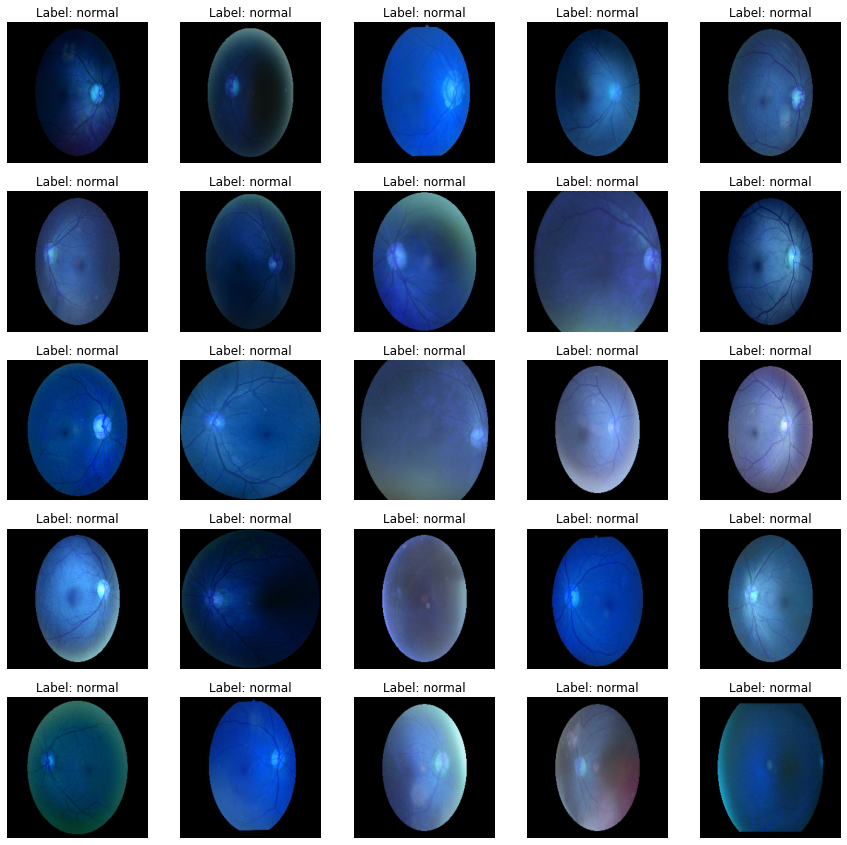

In [ ]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='infecté'
        elif label == 0: 
            str_label='normal'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(norm_df)

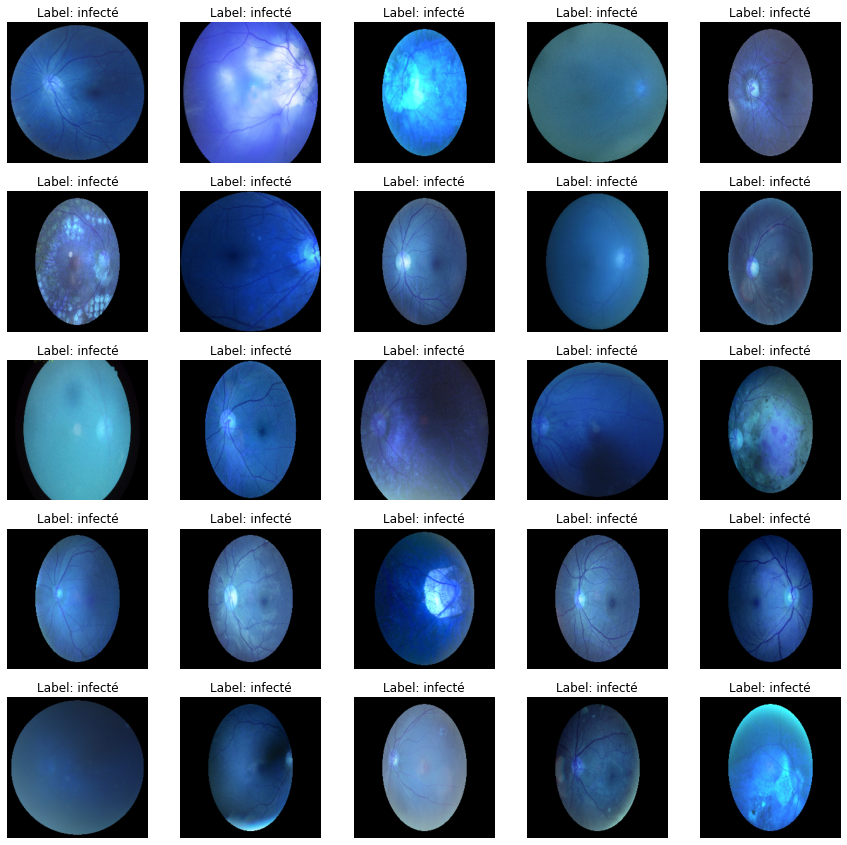

In [ ]:
show_images(infé_df)

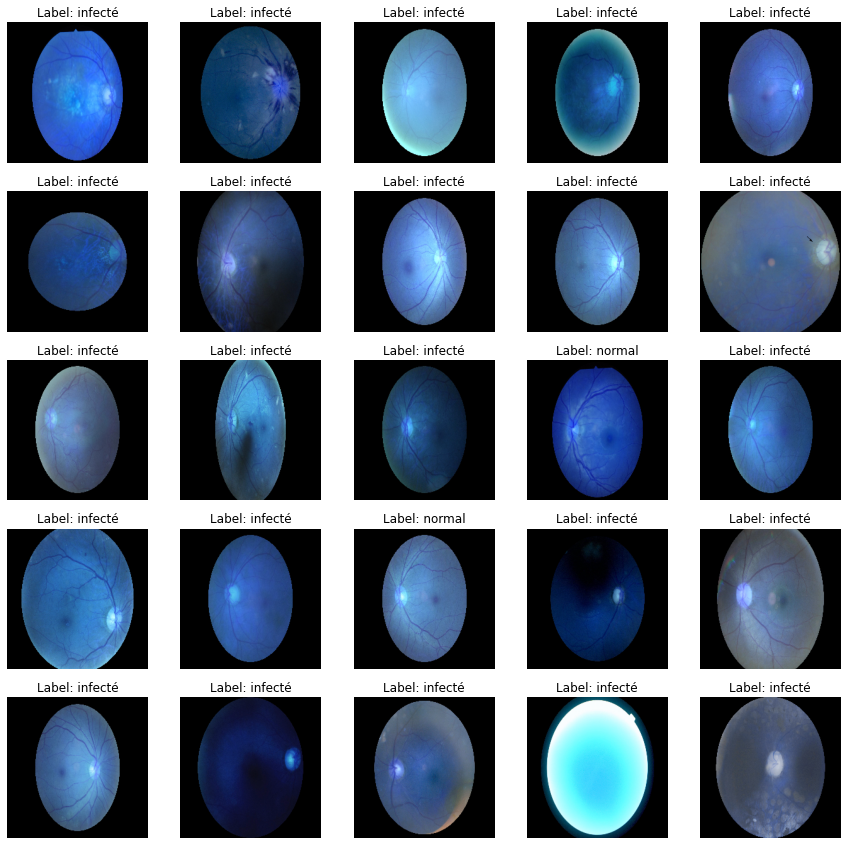

In [ ]:
train = norm_df + infé_df
shuffle(train)
show_images(train)

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
Resn = ResNet50(include_top=False, pooling='max', weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3))

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
for layer in Resn.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(Resn)
model.add(layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [ ]:
opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 23,653,346
Trainable params: 65,634
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
X_train

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
y_train

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
155/155 [==============================] - 28s 121ms/step - loss: 1.5409 - accuracy: 0.5948 - val_loss: 0.6423 - val_accuracy: 0.6321
Epoch 2/50
155/155 [==============================] - 17s 111ms/step - loss: 0.6465 - accuracy: 0.6413 - val_loss: 0.6564 - val_accuracy: 0.6459
Epoch 3/50
155/155 [==============================] - 18s 113ms/step - loss: 0.6223 - accuracy: 0.6512 - val_loss: 0.7838 - val_accuracy: 0.6305
Epoch 4/50
155/155 [==============================] - 18s 115ms/step - loss: 0.6192 - accuracy: 0.6593 - val_loss: 0.6369 - val_accuracy: 0.6280
Epoch 5/50
155/155 [==============================] - 18s 117ms/step - loss: 0.6182 - accuracy: 0.6595 - val_loss: 0.6277 - val_accuracy: 0.6297
Epoch 6/50
155/155 [==============================] - 19s 120ms/step - loss: 0.6055 - accuracy: 0.6666 - val_loss: 0.6000 - val_accuracy: 0.6629
Epoch 7/50
155/155 [==============================] - 18s 118ms/step - loss: 0.6010 - accuracy: 0.6676 - val_loss: 0.6367 - val_ac

# **Validation results**

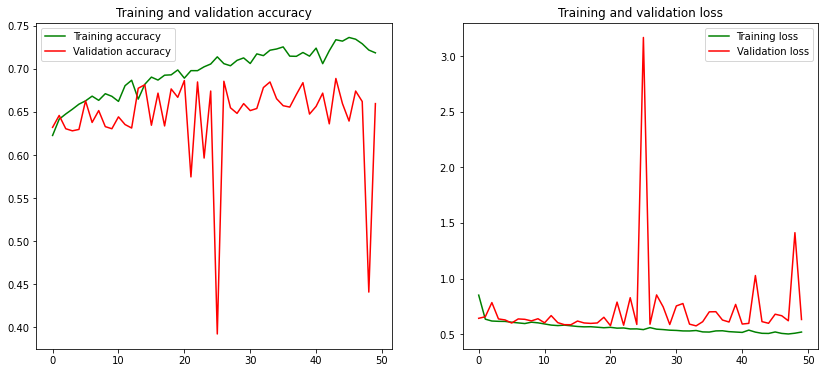

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6316409707069397
Validation accuracy: 0.6596434116363525


In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [ ]:
target_names = ["normal", "infecté"]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.67      0.15      0.25       455
     infecté       0.66      0.96      0.78       779

    accuracy                           0.66      1234
   macro avg       0.66      0.55      0.51      1234
weighted avg       0.66      0.66      0.58      1234



In [ ]:
for layer in Resn.layers:
    layer.trainable = True

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=25,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5057 - accuracy: 0.7228 - val_loss: 0.6829 - val_accuracy: 0.6467
Epoch 2/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5218 - accuracy: 0.7036 - val_loss: 0.6001 - val_accuracy: 0.6313
Epoch 3/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5159 - accuracy: 0.7167 - val_loss: 0.6205 - val_accuracy: 0.6686
Epoch 4/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5029 - accuracy: 0.7301 - val_loss: 0.6405 - val_accuracy: 0.6718
Epoch 5/25
155/155 [==============================] - 18s 117ms/step - loss: 0.4952 - accuracy: 0.7372 - val_loss: 0.5977 - val_accuracy: 0.6791
Epoch 6/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5170 - accuracy: 0.7028 - val_loss: 0.6908 - val_accuracy: 0.6426
Epoch 7/25
155/155 [==============================] - 18s 117ms/step - loss: 0.5034 - accuracy: 0.7161 - val_loss: 0.6364 - val_ac

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6047931909561157
Validation accuracy: 0.6726093888282776


In [ ]:
##############

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(224,224,3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
x=data_augmentation

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model1= Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(2,activation="sigmoid"))

NameError: ignored

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 50178     
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 50178     
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
train_model1= model1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
155/155 [==============================] - 28s 179ms/step - loss: 331.7737 - accuracy: 0.6878 - val_loss: 191.8902 - val_accuracy: 0.6645
Epoch 2/50
155/155 [==============================] - 28s 182ms/step - loss: 138.1446 - accuracy: 0.6999 - val_loss: 156.7186 - val_accuracy: 0.6750
Epoch 3/50
155/155 [==============================] - 27s 176ms/step - loss: 122.3585 - accuracy: 0.7044 - val_loss: 130.9666 - val_accuracy: 0.6645
Epoch 4/50
155/155 [==============================] - 27s 177ms/step - loss: 89.4268 - accuracy: 0.7299 - val_loss: 112.1855 - val_accuracy: 0.6588
Epoch 5/50
155/155 [==============================] - 28s 178ms/step - loss: 69.6447 - accuracy: 0.7455 - val_loss: 99.3073 - val_accuracy: 0.6556
Epoch 6/50
155/155 [==============================] - 27s 177ms/step - loss: 58.4602 - accuracy: 0.7491 - val_loss: 88.5001 - val_accuracy: 0.6540
Epoch 7/50
155/155 [==============================] - 27s 177ms/step - loss: 48.7120 - accuracy: 0.7722 - val_l

In [ ]:
score1 = model1.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score1[0])
print('Validation accuracy:', score1[1])

Validation loss: 43.385318756103516
Validation accuracy: 0.6264181733131409


In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])